## Shapefile update
This file updates the states [shapefile](https://hub.arcgis.com/datasets/1b02c87f62d24508970dc1a6df80c98e/explore) to do four things:
1. Remove Alaska and Hawaii from the shapefile to only have CONUS
1. Dissolve the borders between states so we have a single multipolygon instead of multiple polygons (1 for each state)
1. Expand the CONUS multipolygon by .5 on the border to avoid any issues with slight mischaracterization of borders.
1. Include offshore emissions by adding rectangle to shapefile over Gulf of mexico west coast

<AxesSubplot:>

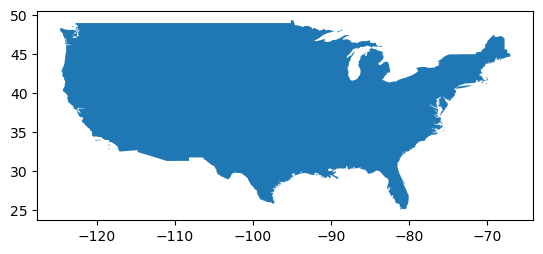

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Load the shapefile of the USA
shapefile_path = "/n/holyscratch01/jacob_lab/lestrada/IMI/CONUS_example_application/integrated_methane_inversion/resources/shapefiles/States_shapefile/States_shapefile.shp"
usa_gdf = gpd.read_file(shapefile_path)

# Define the bounding box coordinates for the contiguous United States (CONUS)
min_lon, min_lat = -125, 24.396308
max_lon, max_lat = -66.934570, 49.384358

# Create a Polygon representing the CONUS bounding box
conus_polygon = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])

# Filter the USA shapefile to only include polygons within the CONUS bounding box
conus_gdf = usa_gdf[usa_gdf.geometry.intersects(conus_polygon)]

# dissolve into a single polygon
aggregated_conus_gdf = conus_gdf.unary_union

# Create a new GeoDataFrame with the aggregated geometry
aggregated_conus_gdf = gpd.GeoDataFrame(geometry=[aggregated_conus_gdf])
aggregated_conus_gdf.plot()


<AxesSubplot:>

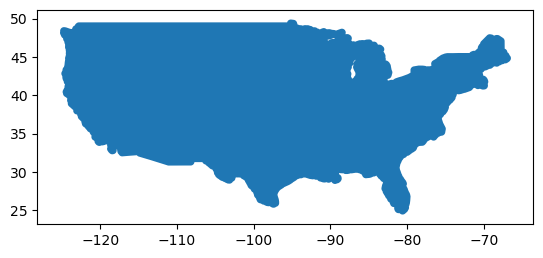

In [2]:
# Here I expand the borders by .25 to avoid getting weird coastal 
# buffers elements for areas that may be cropped out by the shapefile
expanded_gdf = aggregated_conus_gdf.copy()

# Buffer each polygon by 0.25 degrees
buffer_distance = 0.5
expanded_gdf['geometry'] = expanded_gdf['geometry'].buffer(buffer_distance)

# Union the buffered polygons to create a single geometry
expanded_geometry = unary_union(expanded_gdf['geometry'])

# Create a GeoDataFrame with the expanded geometry
expanded_gdf = gpd.GeoDataFrame(geometry=[expanded_geometry])
expanded_gdf.plot()

<AxesSubplot:>

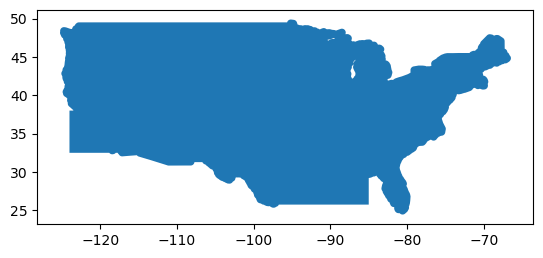

In [3]:
# add rectangle in gulf of mexico to capture gulf emissions
# add rectangle on western coast to capture any just offshore emissions
min_lat = [25.75, 32.5]
max_lat = [30, 38]
min_lon = [-97.5, -124]
max_lon = [-85, -117]
for i in range(len(min_lat)):
    rectangle_coords = [(min_lon[i], min_lat[i]), (max_lon[i], min_lat[i]), (max_lon[i], max_lat[i]), (min_lon[i], max_lat[i])]
    # Create a Polygon geometry for the rectangle
    rectangle_polygon = Polygon(rectangle_coords)
    # Create a GeoDataFrame for the rectangle
    expanded_gdf = expanded_gdf.append({'geometry': rectangle_polygon}, ignore_index=True)
    
# dissolve into single polygon
updated_gdf = gpd.GeoDataFrame(geometry=[expanded_gdf.unary_union])


updated_gdf.plot()

In [4]:
updated_gdf

,geometry
0,"POLYGON ((-85.00000 25.75000, -96.71697 25.750..."


In [5]:
# save out new shapefile
aggregated_shapefile_path = '/n/holyscratch01/jacob_lab/lestrada/IMI/CONUS_example_application/integrated_methane_inversion/resources/shapefiles/conus.shp'
updated_gdf.to_file(aggregated_shapefile_path)